In [1]:
import re
import nltk
import spacy
import gensim
import itertools

from nltk import ngrams
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# Importing model architecture
from bilstm_model_architecture import BiLSTMClassifier

C:\Users\solom\.conda\envs\nlp\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
torch.cuda.is_available()

True

In [3]:
# Cast to GPU if not it will be processed with CPU
device = torch.device('cuda')

In [5]:
df = pd.read_csv('../0. Sample Datasets/spam_sample.csv')

In [6]:
pd.set_option('display.max_column', None) 
df.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   v1      5572 non-null   object
 1   v2      5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [7]:
df.v1.value_counts()

ham     4825
spam     747
Name: v1, dtype: int64

## We will clean all data (regardless of test/val/train) with the same process before proceeding

In [8]:
lem = nltk.WordNetLemmatizer()

stop_words = nltk.corpus.stopwords.words('english')

def preprocessing(sentence):
    sent = sentence.lower()
    
    # Removing selected symbols, keeping numbers
    sent = re.sub("\(|\)|\/|\-|\#|\!|\?|\.|\,|\"|\'", "", sent)
    
    # Removing emails
    sent = re.sub("\S*@\S*\s?", "", sent)
    
    # Removing numbers
    sent = re.sub("\d+", "", sent)
    
    sent = sent.split() # Splitting
    
    # Lemmatisation and stopword removal
    sent = [lem.lemmatize(word) for word in sent if not word in stop_words]
    sent = " ".join(sent)
    
    return sent

In [9]:
print('Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...')

Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...


In [10]:
preprocessing('Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...')

'go jurong point crazy available bugis n great world la e buffet cine got amore wat'

In [11]:
preprocessing('Ok lar... Joking wif u oni...')

'ok lar joking wif u oni'

## Split data

In [12]:
X = df.v2
y = df.v1

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, stratify=y_test)

In [14]:
y_train.value_counts()

ham     3859
spam     598
Name: v1, dtype: int64

In [15]:
y_val.value_counts()

ham     483
spam     74
Name: v1, dtype: int64

In [16]:
y_test.value_counts()

ham     483
spam     75
Name: v1, dtype: int64

In [17]:
X_train.head()

2700    Feb  &lt;#&gt;  is \I LOVE U\" day. Send dis t...
4867    Watching cartoon, listening music &amp; at eve...
669                                 Did u receive my msg?
4958    What i mean was i left too early to check, cos...
50      What you thinked about me. First time you saw ...
Name: v2, dtype: object

In [18]:
y_train.head()

2700    ham
4867    ham
669     ham
4958    ham
50      ham
Name: v1, dtype: object

In [19]:
# Resetting indexes for subsequent processing (less confusing to tally)
X_train.reset_index(drop=True, inplace=True)
X_val.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)

y_train.reset_index(drop=True, inplace=True)
y_val.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

In [20]:
X_train.head()

0    Feb  &lt;#&gt;  is \I LOVE U\" day. Send dis t...
1    Watching cartoon, listening music &amp; at eve...
2                                Did u receive my msg?
3    What i mean was i left too early to check, cos...
4    What you thinked about me. First time you saw ...
Name: v2, dtype: object

In [21]:
y_train.head()

0    ham
1    ham
2    ham
3    ham
4    ham
Name: v1, dtype: object

## Binarising the targets

In [22]:
lb = LabelBinarizer()
y_train_ohe = lb.fit_transform(y_train)
y_val_ohe = lb.transform(y_val)
y_test_ohe = lb.transform(y_test)

In [23]:
lb.classes_

array(['ham', 'spam'], dtype='<U4')

In [24]:
y_train.head()

0    ham
1    ham
2    ham
3    ham
4    ham
Name: v1, dtype: object

In [25]:
y_train_ohe[:5]

array([[0],
       [0],
       [0],
       [0],
       [0]])

## Preprocessing all input text data

In [26]:
X_train = [preprocessing(i) for i in X_train]
X_val = [preprocessing(i) for i in X_val]
X_test = [preprocessing(i) for i in X_test]

In [27]:
X_test[:2]

['alright hooked guy', 'k k: sm chat']

## Tokenising input text

In [28]:
def tokenizer_padding(input_series, max_len, vocabulary=None, train=False):
    
    if type(input_series)!=list:
        input_series = input_series.tolist()
        
    tokenized = [i.split() for i in input_series]
    
    if train:
        # Building vocabulary
        unique_words = ['<PAD>', '<UNK>'] + list(set(itertools.chain.from_iterable(tokenized)))
        vocabulary = dict(zip(unique_words, range(len(unique_words))))
        
    assert vocabulary
    
    # Encoding and padding
    document = []
    
    for i in tokenized:
        tok_sent = [vocabulary[j] if j in vocabulary else 1 for j in i]
        document.append(tok_sent)
        
    for i in range(len(document)):
        if len(document[i])<=max_len:
            document[i] = [0]*(max_len-len(document[i])) + document[i]
        else:
            document[i] = document[i][-max_len:]
            
    output = [np.array(i) for i in document]
    
    if train:
        return np.vstack(output), vocabulary, len(vocabulary)
    else:
        return np.vstack(output)

In [29]:
# Defining parameters for modeling
max_length = seq_len = n_units = 150
d_features = 32

In [30]:
X_train_padded_doc, X_train_vocab, X_train_vocab_size = tokenizer_padding(X_train, max_len=max_length, train=True)
X_val_padded_doc = tokenizer_padding(X_val, max_len=max_length, vocabulary=X_train_vocab)
X_test_padded_doc = tokenizer_padding(X_test, max_len=max_length, vocabulary=X_train_vocab)

In [31]:
X_train_padded_doc[:1]

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0, 5838, 1230, 3142, 5315, 2536, 1875, 6180, 6086,   81,  174,
        4089, 2022,  702, 5722,  406, 4597, 4667, 3014, 7246,  461, 7246,
        4919, 6086, 7246, 1648,   81, 

In [32]:
X_test_padded_doc[:1]

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0, 6804, 

In [33]:
# Convert list to tensors
train_X = torch.tensor(X_train_padded_doc)
train_y = torch.tensor(y_train_ohe.astype(float))

test_X = torch.tensor(X_test_padded_doc)
test_y = torch.tensor(y_test_ohe.astype(float))

val_X = torch.tensor(X_val_padded_doc)
val_y = torch.tensor(y_val_ohe.astype(float))

## Preparing data for training

In [34]:
# Define batch size
batch_size = 16

# FOR TRAINING
# Wrap tensors
train_data = TensorDataset(train_X, train_y)

# Sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# Dataloader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)



# FOR VALIDATING
# Wrap tensors
val_data = TensorDataset(val_X, val_y)

# Sampler for sampling the data during validation for training
val_sampler = SequentialSampler(val_data)

# Dataloader for val set
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

## Modeling without class balancing?

In [35]:
w2v_model = gensim.models.KeyedVectors.load_word2vec_format('D:\DSAI\Pre-Trained Models\word2vec\GoogleNews-vectors-negative300.bin.gz', binary=True)

In [36]:
# Getting embedding matrix for pre-trained Word2Vec model
embeddings_index = dict()

# We will populate the embeddings_index dictionary with all the key<->vector pairs in the Word2Vec model
for line in range(len(w2v_model.index_to_key)):
    embeddings_index[w2v_model.index_to_key[line]] = w2v_model.get_vector(w2v_model.index_to_key[line])
    
# Create a weight matrix for words in training docs
embedding_matrix = np.zeros((X_train_vocab_size, 300)) # Change X_train_vocab_size
for word, i in X_train_vocab.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
        
embedding_matrix.shape

(7454, 300)

In [37]:
X_train_vocab_size

7454

## Defining model

In [38]:
model = BiLSTMClassifier(d_features=embedding_matrix.shape[1], embedding_matrix=embedding_matrix, vocab_size=X_train_vocab_size)

C:\Users\solom\.conda\envs\nlp\lib\site-packages\torch\nn\modules\rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [39]:
model = model.to(device)

In [40]:
print (model)

BiLSTMClassifier(
  (embedding): Embedding(7454, 300, padding_idx=0)
  (lstm): LSTM(300, 300, batch_first=True, dropout=0.2, bidirectional=True)
  (dense1): Linear(in_features=600, out_features=100, bias=True)
  (dense2): Linear(in_features=100, out_features=20, bias=True)
  (dense3): Linear(in_features=20, out_features=1, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (tanh1): Tanh()
  (tanh2): Tanh()
)


In [41]:
from torch.optim import AdamW

# Define optimiser
optimizer = AdamW(model.parameters(), lr=2e-5)

In [42]:
y_train.value_counts()

ham     3859
spam     598
Name: v1, dtype: int64

In [43]:
weight = np.array(y_train.value_counts()[0]/y_train.value_counts()[1])

In [44]:
weight

array(6.45317726)

In [45]:
# Converting list of class weights to a tensor
weights = torch.tensor(weight, dtype=torch.float)

# Push weights to GPU
weights = weights.to(device)

# Define loss function
cross_entropy = nn.BCEWithLogitsLoss(pos_weight=weights)

# No of training epochs
epochs = 30

## Define Training & Evaluation Functions

In [46]:
def train():
    model.train()
    
    total_loss, total_accuracy = 0, 0
    
    # Empty list to save model predictions
    total_preds = []
    
    # Iterate over batches
    for step, batch in enumerate(train_dataloader):
        # Progress update for every 50 batches
        if step%50==0 and not step==0:
            print ('Batch {:>5,} of {:>5,}.'.format(step, len(train_dataloader)))
            
        # Push batch to GPU
        batch = [r.to(device) for r in batch]
        
        sent_id, labels = batch
        
        # Clear previously calculated gradients
        model.zero_grad()
        
        # Get model predictions for the current batch
        preds = model(sent_id)
        
        # Compute loss between actual and predicted values
        loss = cross_entropy(preds, labels)
        
        # Add on to the total loss
        total_loss = total_loss + loss.item()
        
        # Backward pass to calculate gradients
        loss.backward()
        
        # Clip gradients to 1.0. It helps in preventing exploding gradient problem
        torch.nn.utils.clip_grad_norm(model.parameters(), 1.0)
        
        # Update parameters
        optimizer.step()
        
        # Model predictions are stored on GPU, so push it to CPU
        preds = preds.detach().cpu().numpy()
        
        # Append model predictions
        total_preds.append(preds)
        
    # Compute training loss of the epoch
    avg_loss = total_loss / len(train_dataloader)
    
    # Predictions are in the form of (no. of batches, size of batch, no of classes)
    # Reshape the prediction in form of (no of samples, no of classes)
    total_preds = np.concatenate(total_preds, axis=0)
    
    return avg_loss, total_preds

In [47]:
def evaluate():
    print ('\nEvaluating...')
    
    # Deactivate dropout layers
    model.eval()
    
    total_loss, total_accuracy = 0, 0
    
    # Empty list to save model predictions
    total_preds = []
    
    # Iterate over batches
    for step, batch in enumerate(val_dataloader):
        # Progress update for every 50 batches
        if step%50==0 and not step==0:
            print ('Batch {:>5,} of {:>5,}.'.format(step, len(val_dataloader)))
            
        # Push batch to GPU
        batch = [t.to(device) for t in batch]
        
        sent_id, labels = batch
        
        # Deactivate autograd()
        with torch.no_grad():
            
            # Model predictions
            preds = model(sent_id)
            
            # Compute the validation loss between actual and predicted values
            loss = cross_entropy(preds, labels)
            
            total_loss = total_loss + loss.item()
            
            preds = preds.detach().cpu().numpy()
            
            total_preds.append(preds)
            
    # Compute the validation loss of the epoch
    avg_loss = total_loss / len(val_dataloader)
    
    # Reshape the predictions in form of (no of samples, no of classes)
    total_preds = np.concatenate(total_preds, axis=0)
    
    return avg_loss, total_preds

## Iterate through training loop

In [48]:
# Set initial loss to infinite
best_valid_loss = float('inf')

# Empty lists to store training and validation loss of each epoch
train_losses = []
valid_losses = []

# For each epoch
for epoch in range(epochs):
    print ('\nEpoch {:}/ {:}'.format(epoch+1, epochs))
    
    # Train model
    train_loss, _ = train()
    
    # Evaluate model
    valid_loss, _ = evaluate()
    
    # Save the best model
    if valid_loss<best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_model_weights/pytorch_bilstm.pt')
        
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print (f"\nTraining Loss: {train_loss:.5f}")
    print (f"Validation Loss: {valid_loss:.5f}")


Epoch 1/ 30


C:\Users\solom\AppData\Local\Temp\ipykernel_6912\3618230079.py:36: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(model.parameters(), 1.0)


Batch    50 of   279.
Batch   100 of   279.
Batch   150 of   279.
Batch   200 of   279.
Batch   250 of   279.

Evaluating...

Training Loss: 1.19163
Validation Loss: 1.17150

Epoch 2/ 30
Batch    50 of   279.
Batch   100 of   279.
Batch   150 of   279.
Batch   200 of   279.
Batch   250 of   279.

Evaluating...

Training Loss: 1.03747
Validation Loss: 0.79682

Epoch 3/ 30
Batch    50 of   279.
Batch   100 of   279.
Batch   150 of   279.
Batch   200 of   279.
Batch   250 of   279.

Evaluating...

Training Loss: 0.85407
Validation Loss: 0.69211

Epoch 4/ 30
Batch    50 of   279.
Batch   100 of   279.
Batch   150 of   279.
Batch   200 of   279.
Batch   250 of   279.

Evaluating...

Training Loss: 0.69479
Validation Loss: 0.62545

Epoch 5/ 30
Batch    50 of   279.
Batch   100 of   279.
Batch   150 of   279.
Batch   200 of   279.
Batch   250 of   279.

Evaluating...

Training Loss: 0.66612
Validation Loss: 0.73107

Epoch 6/ 30
Batch    50 of   279.
Batch   100 of   279.
Batch   150 of   279.

## Visualise training and validation loss

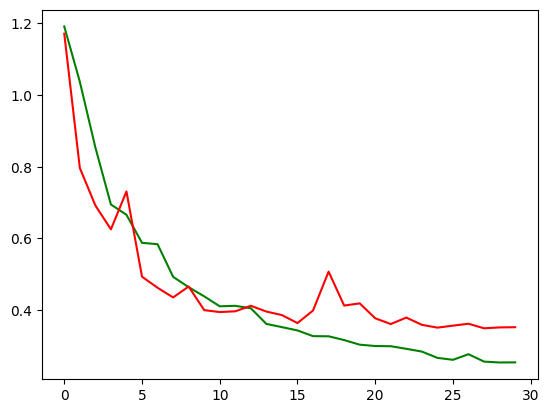

In [49]:
import matplotlib.pyplot as plt
plt.plot(train_losses, 'g', valid_losses, 'r')

## Model evaluation

In [50]:
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score

In [51]:
model_path = 'saved_model_weights/pytorch_bilstm.pt'

model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [52]:
y_preds = model(test_X.to(device))

In [53]:
# Apply sigmoid function to outputs (sigmoid was auto applied by the loss function during training but the model architecture outputs predictions pre-sigmoid application)
y_preds = nn.functional.sigmoid(y_preds)

C:\Users\solom\.conda\envs\nlp\lib\site-packages\torch\nn\functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [54]:
y_preds = y_preds.detach().cpu().numpy()

In [55]:
y_preds[:5]

array([[0.03455034],
       [0.04532771],
       [0.97059387],
       [0.03998303],
       [0.0350887 ]], dtype=float32)

In [56]:
# Change probabilities above to 1 for probabilities above 0.5
y_hat = (y_preds>=0.5).astype(int)

In [57]:
print (classification_report(y_test_ohe, y_hat, target_names=lb.classes_))

              precision    recall  f1-score   support

         ham       0.98      0.98      0.98       483
        spam       0.89      0.88      0.89        75

    accuracy                           0.97       558
   macro avg       0.94      0.93      0.93       558
weighted avg       0.97      0.97      0.97       558



In [58]:
roc_auc_score(y_test_ohe, y_hat)

0.9317184265010352

In [59]:
accuracy_score(y_test_ohe, y_hat)

0.9695340501792115